# Loading the dataset and importing libraries

In [1]:
!pip install h5py
!pip install tensorflow

In [2]:
# Import useful libraries
import pandas as pd
import json
import numpy as np
from scipy.stats.stats import mode
import seaborn as sns
from PIL import Image
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, normalize, StandardScaler

# Classifier models
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict, GridSearchCV 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report


# Statistic libraries
from scipy.optimize import fmin, minimize_scalar
from scipy import stats

# Importing Keras library from Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers.merge import Concatenate
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.python.keras.layers.core import Dense
from tensorflow.python.keras.layers.pooling import GlobalAveragePooling2D
from keras.models import load_model
from os import makedirs

In [3]:
from app import EvaluateAndReport, add_features, plot_features, to_RGB, get_distrib, DeepLearningExplore

In [4]:
# Import Google Drive
from google.colab import drive
drive.mount('/content/drive')

#returns JSON object as a dictionary
f = open('/content/drive/MyDrive/Iceberg/train.json',) # The train.json file needs to be in an "Iceberg" directory

# creating a dataframe
df_raw = pd.DataFrame(json.load(f))

# visualising the first rows
df_raw.head()

Mounted at /content/drive


,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878361, -27.15416, -28.668615, -29.537971...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920305, -14.920363, -12.66633...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


In [5]:
# Visualising info
print(df_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          1604 non-null   object
 1   band_1      1604 non-null   object
 2   band_2      1604 non-null   object
 3   inc_angle   1604 non-null   object
 4   is_iceberg  1604 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 62.8+ KB
None


# Data treatment

In [6]:
# Train/test split for the whole project as we don't have a test dataset
df = df_raw.sample(frac = 0.8, random_state = 42)
df_test = df_raw.drop(df.index)
# Changing inc_angle from object to float64
df.replace('na', np.NaN, inplace = True) # Replacing the 'na' text in inc_angle by NaN
df['inc_angle'].astype('float', copy = False) # Casting inc_angle to float works with the NaN
df[df.inc_angle.isna()] # 133 NaN
print(df.info()) # inc_angle is now float64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1283 entries, 530 to 546
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          1283 non-null   object 
 1   band_1      1283 non-null   object 
 2   band_2      1283 non-null   object 
 3   inc_angle   1175 non-null   float64
 4   is_iceberg  1283 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 60.1+ KB
None


In [7]:
naive_base = pd.DataFrame(df.band_1.to_list(), index=df.index, columns=[f"band_1_{i}" for i in range(75*75)]).join(pd.DataFrame(df.band_2.to_list(), index=df.index, columns=[f"band_2_{i}" for i in range(75*75)]))

In [8]:
# splitting the bands into single elements
df = df.join(naive_base)
df.head()

,id,band_1,band_2,inc_angle,is_iceberg,band_1_0,band_1_1,band_1_2,band_1_3,band_1_4,band_1_5,band_1_6,band_1_7,band_1_8,band_1_9,band_1_10,band_1_11,band_1_12,band_1_13,band_1_14,band_1_15,band_1_16,band_1_17,band_1_18,band_1_19,band_1_20,band_1_21,band_1_22,band_1_23,band_1_24,band_1_25,band_1_26,band_1_27,band_1_28,band_1_29,band_1_30,band_1_31,band_1_32,band_1_33,band_1_34,...,band_2_5585,band_2_5586,band_2_5587,band_2_5588,band_2_5589,band_2_5590,band_2_5591,band_2_5592,band_2_5593,band_2_5594,band_2_5595,band_2_5596,band_2_5597,band_2_5598,band_2_5599,band_2_5600,band_2_5601,band_2_5602,band_2_5603,band_2_5604,band_2_5605,band_2_5606,band_2_5607,band_2_5608,band_2_5609,band_2_5610,band_2_5611,band_2_5612,band_2_5613,band_2_5614,band_2_5615,band_2_5616,band_2_5617,band_2_5618,band_2_5619,band_2_5620,band_2_5621,band_2_5622,band_2_5623,band_2_5624
530,f06ecb96,"[-22.622971, -19.042347, -18.257372, -18.69734...","[-23.36264, -22.62306, -23.962086, -24.38596, ...",30.4878,1,-22.622971,-19.042347,-18.257372,-18.697346,-20.440437,-20.440529,-16.872957,-18.697704,-17.637222,-14.771990,-15.064069,-18.366076,-18.698151,-19.281404,-18.366344,-17.058575,-19.281673,-21.310917,-18.698689,-17.738623,-20.305080,-19.526810,-18.047298,-16.874477,-17.153282,-17.840750,-17.441418,-16.604786,-17.153641,-17.739517,-17.441776,-16.694231,-15.368186,-14.774137,-16.694500,...,-24.389721,-23.366758,-21.313601,-22.627266,-24.390078,-21.945848,-24.390257,-22.280142,-21.314140,-20.868700,-22.111748,-24.836233,-24.610701,-23.762714,-21.784298,-21.314764,-22.112286,-24.176765,-23.368282,-23.967636,-26.605476,-23.967815,-26.062611,-25.551620,-22.453671,-23.763790,-25.803671,-24.392139,-23.968441,-22.282114,-21.948090,-22.282293,-24.178108,-24.392677,-22.992010,-22.282654,-22.282743,-23.764866,-25.308275,-23.969429
1140,974931df,"[-27.235119, -26.907366, -24.170664, -24.17072...","[-32.01276, -29.514042, -26.907423, -29.090368...",38.4591,1,-27.235119,-26.907366,-24.170664,-24.170721,-24.653395,-23.279133,-29.959793,-27.930696,-27.930754,-22.865665,-20.727779,-19.972065,-25.432146,-28.686749,-25.432259,-24.409208,-22.666262,-26.908094,-24.171391,-21.556082,-20.887661,-20.887661,-23.279917,-25.993223,-25.993280,-23.070776,-23.070776,-23.494617,-25.708639,-27.577129,-30.927008,-30.430592,-30.430592,-25.433098,-26.908876,...,-27.934340,-31.456221,-29.094288,-29.094288,-29.094345,-29.518187,-27.580044,-25.711666,-26.911680,-29.094570,-28.304455,-29.963997,-28.304567,-29.518581,-29.518581,-29.094851,-29.094906,-32.017525,-31.457005,-30.434010,-32.017635,-34.711662,-27.935349,-25.997204,-27.240219,-29.095299,-28.691288,-25.436798,-24.910276,-28.305351,-28.691511,-29.964893,-29.095634,-27.581276,-27.935907,-29.965117,-29.095804,-28.305687,-29.095917,-30.931379
168,d6566373,"[-28.63821, -26.238758, -29.042387, -29.042442...","[-25.944237, -25.659485, -28.252216, -31.40442...",39.5048,0,-28.638210,-26.238758,-29.042387,-29.042442,-25.944458,-25.944511,-27.528191,-27.187578,-29.042713,-29.466555,-29.912138,-31.965439,-36.402470,-36.402470,-33.208508,-30.381977,-28.252926,-27.188070,-25.945168,-26.860371,-27.883476,-29.467155,-29.467211,-27.188398,-27.188452,-28.253418,-28.639574,-28.639574,-30.879105,-28.639683,-28.253635,-28.253691,-25.945875,-25.945930,-27.529612,...,-28.255329,-30.384491,-26.862720,-26.546890,-26.862829,-27.190638,-28.641705,-29.915142,-28.641815,-27.886101,-28.255823,-27.531633,-27.531689,-27.191076,-25.663364,-24.609291,-27.191238,-29.915688,-29.915688,-29.046431,-29.046486,-29.915852,-31.969154,-33.212170,-31.408689,-27.886921,-29.046812,-28.256699,-26.243347,-26.548203,-27.191952,-25.121138,-26.243513,-28.643074,-29.916512,-31.409237,-32.569130,-27.887520,-24.127768,-25.664623
135,6706ea46,"[-22.52327, -20.36145, -18.631905, -19.001574,...","[-26.236002, -27.819691, -25.408276, -25.14897...",36.1091,1,-22.523270,-20.361450,-18.631905,-19.001574,-19.257124,-18.753517,-21.974827,-20.661316,-20.215853,-19.388000,-21.131067,-21.458941,-19.93123

In [9]:
# adding statistics
df = add_features(df,1)
df = add_features(df,2)

# Supervised learning models

In [10]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error

# selecting the prediction target and the model features
y = df["is_iceberg"]
X_stats = df.loc[:,['max_b1','min_b1','median_b1','mean_b1','argmax_b1','argmin_b1','max_b2','min_b2','median_b2','mean_b2','argmax_b2','argmin_b2']]

# split data into training and validation data, for both features and target
# The split is based on a random number generator. 
# Supplying a numeric value to the random_state argument guarantees we get the same 
# split every time we run this script.
X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)

## Decision Tree Classifier

--- Grid Search Report ---
Best parameters for DecisionTreeClassifier() :
 {'max_features': 12, 'min_samples_leaf': 5} with f1 score 0.689
--- Cross Validation Report ---
Mean accuracy score 0.708 with std 0.038
Mean f1 score 0.692 with std 0.039
Mean precision score 0.688 with std 0.043
Mean recall score 0.698 with std 0.043
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.717
 f1 : 0.717
 precision : 0.701
 recall : 0.732
Confusion matrix for the test sample :


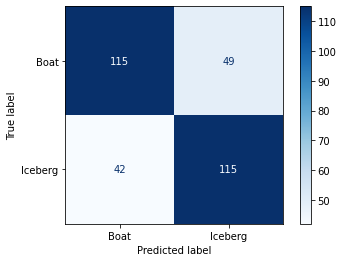

In [11]:
df_stats = df.loc[:,['id','is_iceberg','inc_angle','is_iceberg','max_b1','min_b1','median_b1','mean_b1','argmax_b1','argmin_b1','max_b2','min_b2','median_b2','mean_b2','argmax_b2','argmin_b2']]
er = EvaluateAndReport(df_stats, X_train, X_test, y_train, y_test)

param_grid = [{
    'min_samples_leaf': [2,3,4,5,6],
    'max_features': [4,8,12]
}]
er.cv_cv = 5
er.X_train = X_train
er.y_train = y_train
er.grid_cross_test_report(DecisionTreeClassifier(), param_grid)

In [12]:
DCT_stats = er.last_best

## KNN

--- Grid Search Report ---
Best parameters for KNeighborsClassifier() :
 {'n_neighbors': 6} with f1 score 0.366
--- Cross Validation Report ---
Mean accuracy score 0.526 with std 0.016
Mean f1 score 0.357 with std 0.024
Mean precision score 0.496 with std 0.033
Mean recall score 0.28 with std 0.026
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.523
 f1 : 0.386
 precision : 0.522
 recall : 0.306
Confusion matrix for the test sample :


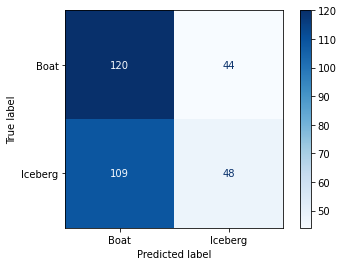

In [13]:
from sklearn.neighbors import KNeighborsClassifier

er_KNN = EvaluateAndReport(df_stats, X_train, X_test, y_train, y_test)
param_grid_knn = [{
    'n_neighbors': range(2,12,4)
}]
er_KNN.cv_cv = 8
er_KNN.X_train = X_train
er_KNN.y_train = y_train
er_KNN.grid_cross_test_report(KNeighborsClassifier(), param_grid_knn)

In [14]:
KNN_stats = er_KNN.last_best

In [15]:
X_train_stats = X_train
y_train_stats = y_train
X_test_stats = X_test
y_test_stats = y_test

## Introducing a PCA

In [16]:
from app import get_pca_df
pca_5 = get_pca_df(df, naive_base, 5)
pca_10 = get_pca_df(df, naive_base, 10)
pca_20 = get_pca_df(df, naive_base, 20)
pca_50 = get_pca_df(df, naive_base, 50)
pca_100 = get_pca_df(df, naive_base, 100)
pca_200 = get_pca_df(df, naive_base, 200)
pca_500 = get_pca_df(df, naive_base, 500)

## Decision Tree Classifier - PCA

--- Grid Search Report ---


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


50 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 942, in fit
    X_idx_sorted=X_idx_sorted,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 308, in fit
    raise ValueError("max_features must be in (0, n_features]")
ValueError: max_features must be in (0, 

Best parameters for DecisionTreeClassifier() :
 {'max_features': 4, 'min_samples_leaf': 5} with f1 score 0.635
--- Cross Validation Report ---
Mean accuracy score 0.673 with std 0.015
Mean f1 score 0.635 with std 0.028
Mean precision score 0.67 with std 0.03
Mean recall score 0.609 with std 0.059
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.676
 f1 : 0.69
 precision : 0.648
 recall : 0.739
Confusion matrix for the test sample :
--- Grid Search Report ---


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


25 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 942, in fit
    X_idx_sorted=X_idx_sorted,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 308, in fit
    raise ValueError("max_features must be in (0, n_features]")
ValueError: max_features must be in (0, 

Best parameters for DecisionTreeClassifier() :
 {'max_features': 8, 'min_samples_leaf': 5} with f1 score 0.684
--- Cross Validation Report ---
Mean accuracy score 0.719 with std 0.021
Mean f1 score 0.693 with std 0.02
Mean precision score 0.717 with std 0.034
Mean recall score 0.671 with std 0.024
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.717
 f1 : 0.723
 precision : 0.692
 recall : 0.758
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for DecisionTreeClassifier() :
 {'max_features': 12, 'min_samples_leaf': 5} with f1 score 0.689
--- Cross Validation Report ---
Mean accuracy score 0.707 with std 0.017
Mean f1 score 0.676 with std 0.026
Mean precision score 0.706 with std 0.026
Mean recall score 0.651 with std 0.056
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.726
 f1 : 0.707
 precision : 0.741
 recall : 0.675
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for Decisi

[{'accuracy': 0.673, 'f1': 0.635, 'precision': 0.67, 'recall': 0.609},
 {'accuracy': 0.719, 'f1': 0.693, 'precision': 0.717, 'recall': 0.671},
 {'accuracy': 0.707, 'f1': 0.676, 'precision': 0.706, 'recall': 0.651},
 {'accuracy': 0.663, 'f1': 0.628, 'precision': 0.655, 'recall': 0.605},
 {'accuracy': 0.63, 'f1': 0.6, 'precision': 0.612, 'recall': 0.589},
 {'accuracy': 0.581, 'f1': 0.532, 'precision': 0.563, 'recall': 0.505},
 {'accuracy': 0.575, 'f1': 0.539, 'precision': 0.553, 'recall': 0.527}]

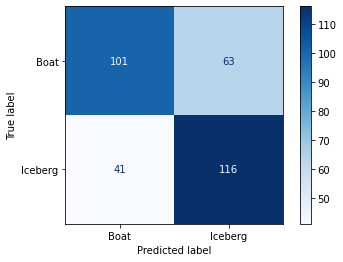

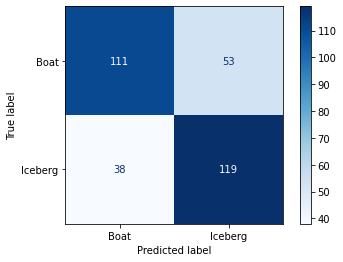

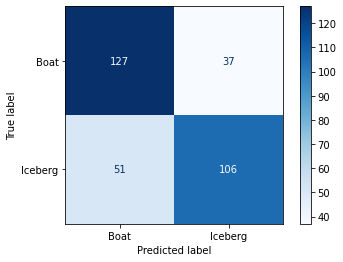

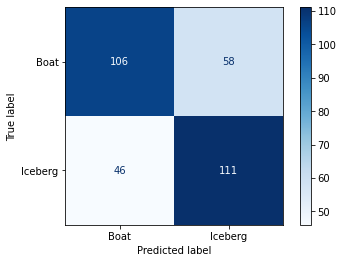

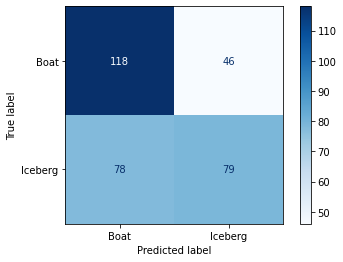

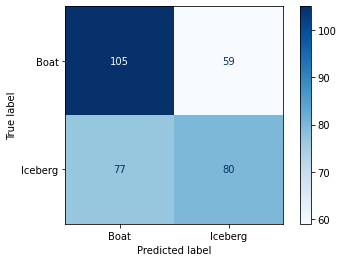

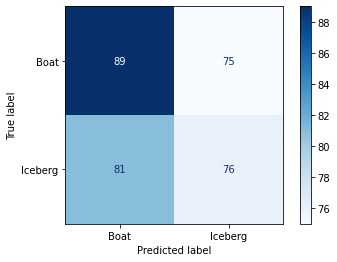

In [17]:
param_grid = [{
    'min_samples_leaf': [2,3,4,5,6],
    'max_features': [4,8,12]
}]

train_scores = []
for dtset in [pca_5, pca_10, pca_20, pca_50, pca_100, pca_200, pca_500] :
  y = dtset["is_iceberg"]
  X_pca = dtset.drop('is_iceberg',axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_pca, y, random_state = 0)
  er_PCA = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er_PCA.cv_cv = 5 
  er_PCA.grid_cross_test_report(DecisionTreeClassifier(), param_grid)
  train_scores.append(er_PCA.best_scores_t)

train_scores

In [18]:
DCT_PCA = er_PCA.last_best

## KNN - PCA

--- Grid Search Report ---
Best parameters for KNeighborsClassifier() :
 {'n_neighbors': 16} with f1 score 0.677
--- Cross Validation Report ---
Mean accuracy score 0.676 with std 0.013
Mean f1 score 0.677 with std 0.016
Mean precision score 0.638 with std 0.019
Mean recall score 0.722 with std 0.042
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.701
 f1 : 0.711
 precision : 0.674
 recall : 0.752
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for KNeighborsClassifier() :
 {'n_neighbors': 8} with f1 score 0.711
--- Cross Validation Report ---
Mean accuracy score 0.728 with std 0.01
Mean f1 score 0.711 with std 0.011
Mean precision score 0.711 with std 0.013
Mean recall score 0.711 with std 0.018
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.723
 f1 : 0.723
 precision : 0.707
 recall : 0.739
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for KNeighborsClassifier() :
 {'n_n

[{'accuracy': 0.676, 'f1': 0.677, 'precision': 0.638, 'recall': 0.722},
 {'accuracy': 0.728, 'f1': 0.711, 'precision': 0.711, 'recall': 0.711},
 {'accuracy': 0.713, 'f1': 0.702, 'precision': 0.69, 'recall': 0.715},
 {'accuracy': 0.704, 'f1': 0.703, 'precision': 0.667, 'recall': 0.744},
 {'accuracy': 0.691, 'f1': 0.694, 'precision': 0.652, 'recall': 0.742},
 {'accuracy': 0.681, 'f1': 0.682, 'precision': 0.643, 'recall': 0.729},
 {'accuracy': 0.676, 'f1': 0.673, 'precision': 0.642, 'recall': 0.709}]

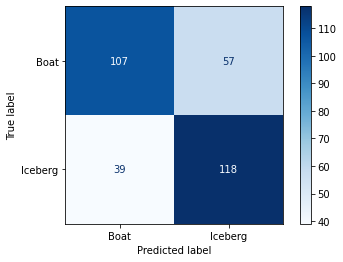

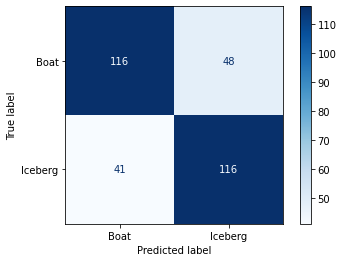

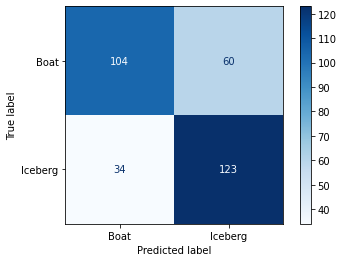

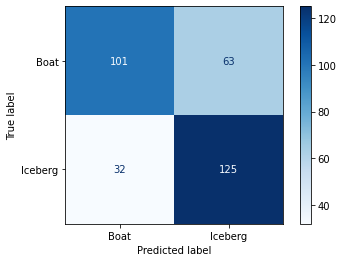

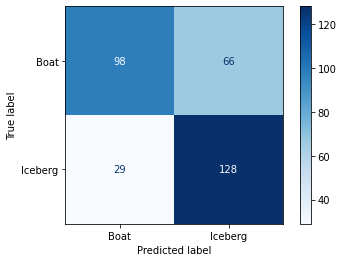

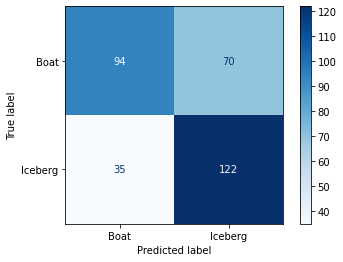

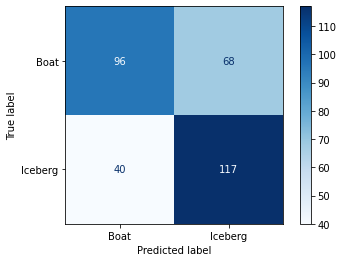

In [19]:
param_grid_knn = [{
    'n_neighbors': range(4,20,4)
}]

train_scores_knn = []
for dtset in [pca_5, pca_10, pca_20, pca_50, pca_100, pca_200, pca_500] :
  y = dtset["is_iceberg"]
  X_pca = dtset.drop('is_iceberg',axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_pca, y, random_state = 0)
  er_PCA_knn = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er_PCA_knn.cv_cv = 5 
  er_PCA_knn.grid_cross_test_report(KNeighborsClassifier(), param_grid_knn)
  train_scores_knn.append(er_PCA_knn.best_scores_t)

train_scores_knn

In [20]:
KNN_PCA = er_PCA_knn.last_best

## Combining PCA & Features

In [21]:
df_stats = df_stats.loc[:,~df_stats.columns.duplicated()]
df_5 = df_stats.drop(['inc_angle','id'],axis=1).join(pca_5.drop('is_iceberg',axis=1)).dropna()
df_20 = df_stats.drop(['inc_angle','id'],axis=1).join(pca_20.drop('is_iceberg',axis=1)).dropna()
df_50 = df_stats.drop(['inc_angle','id'],axis=1).join(pca_50.drop('is_iceberg',axis=1)).dropna()
df_100 = df_stats.drop(['inc_angle','id'],axis=1).join(pca_100.drop('is_iceberg',axis=1)).dropna()

## Decision Tree Classifier - Combined

--- Grid Search Report ---
Best parameters for DecisionTreeClassifier() :
 {'max_features': 12, 'min_samples_leaf': 5} with f1 score 0.736
--- Cross Validation Report ---
Mean accuracy score 0.734 with std 0.031
Mean f1 score 0.71 with std 0.038
Mean precision score 0.73 with std 0.04
Mean recall score 0.693 with std 0.056
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.76
 f1 : 0.756
 precision : 0.753
 recall : 0.758
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for DecisionTreeClassifier() :
 {'max_features': 8, 'min_samples_leaf': 5} with f1 score 0.73
--- Cross Validation Report ---
Mean accuracy score 0.734 with std 0.035
Mean f1 score 0.717 with std 0.045
Mean precision score 0.717 with std 0.035
Mean recall score 0.719 with std 0.073
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.729
 f1 : 0.72
 precision : 0.727
 recall : 0.713
Confusion matrix for the test sample :
--- Grid Search Report ---
Best

[{'accuracy': 0.734, 'f1': 0.71, 'precision': 0.73, 'recall': 0.693},
 {'accuracy': 0.734, 'f1': 0.717, 'precision': 0.717, 'recall': 0.719},
 {'accuracy': 0.708, 'f1': 0.679, 'precision': 0.706, 'recall': 0.656},
 {'accuracy': 0.697, 'f1': 0.676, 'precision': 0.677, 'recall': 0.676}]

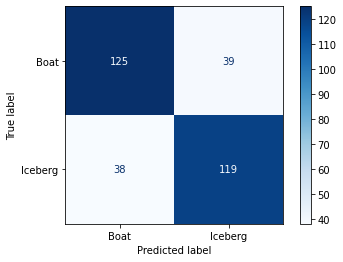

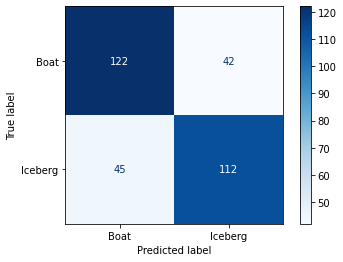

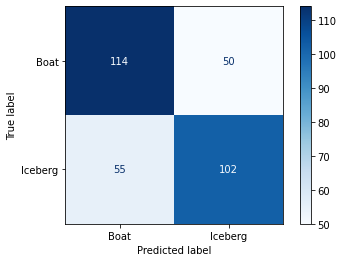

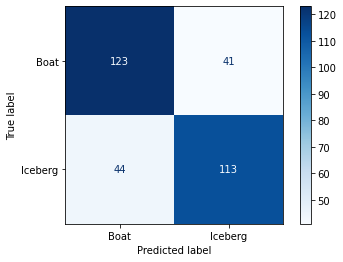

In [22]:
train_scores_mix_dct = []

param_grid = [{
    'min_samples_leaf': [2,3,4,5,6],
    'max_features': [4,8,12]
}]

for dtset in [df_5, df_20, df_50, df_100] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop(['is_iceberg'],axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er_dct_comb = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er_dct_comb.cv_cv = 5 
  er_dct_comb.grid_cross_test_report(DecisionTreeClassifier(), param_grid)
  train_scores_mix_dct.append(er_dct_comb.best_scores_t)

train_scores_mix_dct

In [23]:
DCT_comb = er_dct_comb.last_best

## KNN - Combined

--- Grid Search Report ---
Best parameters for KNeighborsClassifier() :
 {'n_neighbors': 14} with f1 score 0.383
--- Cross Validation Report ---
Mean accuracy score 0.524 with std 0.025
Mean f1 score 0.383 with std 0.031
Mean precision score 0.492 with std 0.042
Mean recall score 0.313 with std 0.028
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.514
 f1 : 0.409
 precision : 0.505
 recall : 0.344
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for KNeighborsClassifier() :
 {'n_neighbors': 12} with f1 score 0.385
--- Cross Validation Report ---
Mean accuracy score 0.531 with std 0.032
Mean f1 score 0.385 with std 0.056
Mean precision score 0.501 with std 0.05
Mean recall score 0.313 with std 0.056
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.514
 f1 : 0.391
 precision : 0.505
 recall : 0.318
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for KNeighborsClassifier() :
 {'n_

[{'accuracy': 0.524, 'f1': 0.383, 'precision': 0.492, 'recall': 0.313},
 {'accuracy': 0.531, 'f1': 0.385, 'precision': 0.501, 'recall': 0.313},
 {'accuracy': 0.53, 'f1': 0.384, 'precision': 0.499, 'recall': 0.313},
 {'accuracy': 0.525, 'f1': 0.388, 'precision': 0.494, 'recall': 0.32}]

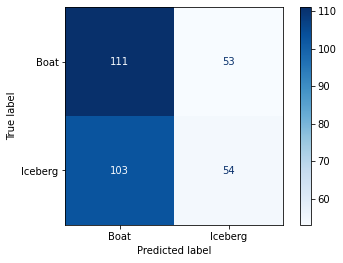

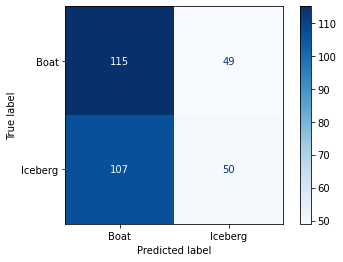

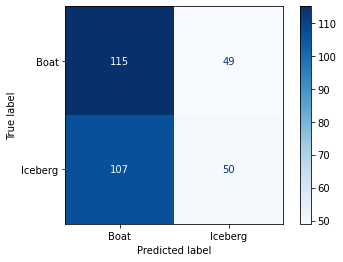

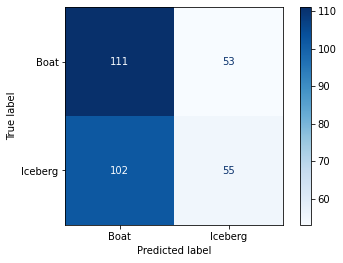

In [24]:
train_scores_mix_knn = []

param_grid_knn = [{
    'n_neighbors': range(2,20,2)
}]

for dtset in [df_5, df_20, df_50, df_100] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop(['is_iceberg'],axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er_knn_cmb = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er_knn_cmb.cv_cv = 5
  er_knn_cmb.grid_cross_test_report(KNeighborsClassifier(), param_grid_knn)
  train_scores_mix_knn.append(er_knn_cmb.best_scores_t)

train_scores_mix_knn

In [25]:
KNN_comb = er_knn_cmb.last_best

# Unsupervised learning with Keras and Tensorflow

## Formatting the data

In [26]:
X_b1=np.array(
    [np.array(band).astype(np.float64).reshape(75, 75) for band in df["band_1"]]
    )

X_b2=np.array(
    [np.array(band).astype(np.float64).reshape(75, 75) for band in df["band_2"]]
    )

train_cnn = np.concatenate([X_b1[:, :, :, np.newaxis], X_b2[:, :, :, np.newaxis]], axis=-1)
target_cnn=df['is_iceberg']

In [27]:
from sklearn.model_selection import train_test_split

X_train_cnn, X_valid_cnn, y_train_cnn, y_valid_cnn = train_test_split(train_cnn, target_cnn, random_state=42, train_size=0.7)

## First Model

In [34]:
covnet = DeepLearningExplore(df, X_train_cnn, X_valid_cnn, y_train_cnn, y_valid_cnn)

cv_1 = covnet.create_model(4, 3)

ValueError: ignored